In [32]:
import pandas as pd
import unicodedata
import string
import re
import numpy as np
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from statistics import mean
plt.style.use('ggplot')


In [20]:
### Creates initial dataframe from .txt files
parties = ['republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'republican', 'republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'democrat']
pres = ['bush', 'carter', 'clinton', 'eisenhower', 'fdroosevelt', 'ford', 'gwbush', 'hoover', 'kennedy', 'lbjohnson', 'nixon', 'obama', 'reagan', 'truman']
war = ['war', 'nw', 'nw', 'nw', 'war', 'nw', 'war', 'nw', 'war', 'war', 'war', 'war', 'nw', 'war']
pres_dict = {}
for i, v in enumerate(pres):
    pres_dict[v]= {}
    pres_dict[v]['party'] = parties[i]

## imports .txt files and puts them into a dictionary
import os
data = []
for i, p in enumerate(pres):
    folder = 'corpus/' + p + '/'
    for filename in os.listdir(folder): 
        indiv = []
        indiv.append(p)
        indiv.append(parties[i])
        indiv.append(war[i])
        path = folder + filename
        if os.path.isfile(path) and filename.endswith(".txt"): 
            with open(path, "r") as file: 
                indiv.append(file.read())
            data.append(indiv)

# for filename in os.listdir('corpus_addendum/'): 
#     indiv = []
#     path = folder + filename
#     print(path)
#     if os.path.isfile(path) and filename.endswith(".txt"): 
#         with open(path, "r") as file:
#             p = filename.split('-')[1][:-4]
#             indiv.append(p)
#             indiv.append(pres_dict[p]['party'])
#             indiv.append(file.read())
#     data.append(indiv)

#converts the dictionary to a dataframe
df = pd.DataFrame (data, columns = ['name', 'party', 'war','speech'])

### splits the speech into title, date, text
def get_text(x):
    idx = x.find('>', x.find('>')+1, 100)
    return x[idx+1:]

df['title'] = df['speech'].apply(lambda x: x.split('"')[1])
df['date'] = df['speech'].apply(lambda x: x.split('"')[3])
df['text'] = df['speech'].apply(get_text)

def is_speech_type(string, speech_type):
    if string.lower().find(speech_type)>=0:
        return True
    else:
        return False

speech_type = ['interview', 'debate', 'inaugural address', 'state of the union', 'press conference']
for i in speech_type:
    df[i] = df.title.apply(lambda x: is_speech_type(x, i))

## Use this function to find parts of the debates that belong to each speaker
def find_between( s, first, last ):
    result = ''
    while True:
        try:
            start = s.index(first) + len(first)
            end = s.index( last, start )
            result += s[start:end] + ' '
            s = s[end:]
        except ValueError:
            return result

In [10]:
trump = np.loadtxt('corpus/trump_speech/trump.txt')

ValueError: could not convert string to float: 'SPEECH'

In [15]:
trump_speeches = string.split("SPEECH")

AttributeError: module 'string' has no attribute 'split'

In [698]:
len(trump_speeches)

12

In [21]:
df.head()

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False,False
1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...,False,False,False,False,False
2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t...",False,False,False,False,False
3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...,False,False,False,False,False
4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...,False,False,False,False,False


In [631]:
df.loc[548, 'text']

KeyError: 548

In [22]:
idx = [5 ,13, 23, 26, 28, 41,60, 252, 253, 260, 265, 449, 453]
opponent = [['clinton', 'democrat'], ['dukakis', 'democrat'], ['ford', 'republican'], ['ford', 'republican'],
            ['ford', 'republican'], ['reagan', 'republican'], ['dole', 'republican'], ['nixon', 'republican'], ['nixon', 'republican'],
            ['nixon', 'republican'], ['nixon', 'republican'], ['mondale','democrat'], ['mondale','democrat']]
        
delimiters = [['Bush.>', '>', '<Governor Clinton.', '>'], ['BUSH:>', '<', '<DUKAKIS:','>'], 
              ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'], ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'], 
              ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'],['THE PRESIDENT.>', '<', '<GOVERNOR REAGAN.', '>'],
             ['<PRESIDENT CLINTON:>', '<', '<SENATOR DOLE:', '<'],['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'],
              ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], 
              ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], ['<The President.>', '<', '<Mr. Mondale.', '>'],
              ['<PRESIDENT REAGAN:>', '<', '<MR. MONDALE:', '>']]
opponents = []
for i in range(len(idx)):
    text = df.loc[idx[i], 'text']
    df.loc[idx[i],'text'] = find_between(df.loc[idx[i],'text'], delimiters[i][0], delimiters[i][1])
    opponent_text = find_between(text, delimiters[i][2], delimiters[i][3])
    #print(f'for {idx[i]}, delimited opponent {opponent[i]} between {delimiters[i][2]} and {delimiters[i][3]}')
    opponents.append(opponent[i] + [0, 0, 0, 0] + [opponent_text] + [False, True, False, False, False])
opponents = pd.DataFrame(data = opponents, columns = df.columns)
df = pd.concat([df, opponents])

In [23]:
import pprint
# Requests sends and recieves HTTP requests.
import requests

# Beautiful Soup parses HTML documents in python.
from bs4 import BeautifulSoup

url = 'https://www.debates.org/voter-education/debate-transcripts/'
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')

classes = []
class_num = [i for i in range(100, 141)]
for v in [138, 139, 133, 140, 135, 136, 137, 134, 130, 132, 129, 127, 121, 122, 118, 101]:
    class_num.remove(v)

for i in class_num:
    classes.append("page_item page-item-"+str(i))

debate_names = [['kaine', 'democrat', 'pence', 'republican'], ['obama', 'democrat', 'romney', 'republican'],
                ['obama', 'democrat', 'romney', 'republican'], ['biden', 'democrat', 'ryan', 'republican'],
               ['obama', 'democrat', 'romney', 'republican'], ['mccain', 'republican', 'obama', 'democrat'],
               ['biden', 'democrat', 'palin', 'republican'], ['mccain', 'republican', 'obama', 'democrat'],
               ['mccain', 'republican', 'obama', 'democrat'], ['bush', 'republican', 'kerry', 'democrat'],
               ['bush','republican','kerry','democrat'], ['cheney', 'republican', 'edwards', 'democrat'],
               ['bush', 'republican', 'kerry', 'democrat'], ['gore', 'democrat', 'bush', 'republican'],
                ['lieberman', 'democrat', 'cheney', 'republican'], ['gore', 'democrat', 'bush', 'republican'],
                ['gore', 'democrat', 'bush', 'republican'], ['gore', 'democrat', 'kemp', 'republican'],
                ['clinton', 'democrat', 'dole', 'republican'], ['gore', 'democrat', 'quayle', 'republican'],
                ['clinton', 'democrat', 'bush', 'republican'], ['clinton', 'democrat', 'bush', 'republican'],
                ['bush', 'republican', 'dukakis', 'democrat'], ['bentsen', 'democrat', 'quayle', 'republican'],
                ['bush', 'republican','ferraro', 'democrat']]

### Gets text from each speech
links = []
for i in classes:
    x = soup.find_all(class_= i)
    links.append('http://debates.org/'+ str(x).split('"')[3])


results = []
for i, link in enumerate(links):
    req = requests.get(link)
    soup_link = BeautifulSoup(req.content, 'html.parser')
    text = soup_link.get_text()
    text = text.lower()
    for v in [0, 2]:
        text_1 = find_between(text, '\n'+debate_names[i][v]+":", ':')
        results.append([debate_names[i][v], debate_names[i][v+1]] + [0, 0, 0, 0] + [text_1] + [False, True, False, False, False])
for i in [18, 20, 24, 27, 31, 33]:
     results[i][0]=results[i][0].replace("bush", "gwbush")
more_debates = pd.DataFrame(data = results, columns = df.columns)
df = pd.concat([df, more_debates])


In [ ]:
## I loaded Trump's speeches to use as a test set later on.

In [720]:
politico = 'https://www.politico.com/story/2016/07/full-transcript-donald-trump-nomination-acceptance-speech-at-rnc-225974'

In [721]:
req = requests.get(politico)
soup_link = BeautifulSoup(req.content, 'html.parser')
text = soup_link.get_text()
text = text.lower()

In [734]:
speech= text.split("politico thursday afternoon")

In [743]:
trump_speeches.append(speech[2].split("follow @ politico")[0])

In [24]:
df = df.reset_index()

In [635]:
df.index

RangeIndex(start=0, stop=549, step=1)

## EDA!

In [25]:
df.head()

,index,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference
0,0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False,False
1,1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...,False,False,False,False,False
2,2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t...",False,False,False,False,False
3,3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...,False,False,False,False,False
4,4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...,False,False,False,False,False


In [636]:
df.count()

index                 549
name                  549
party                 549
war                   549
speech                549
title                 549
date                  549
text                  549
interview             549
debate                549
inaugural address     549
state of the union    549
press conference      549
dtype: int64

In [637]:
print('Speeches by president')
print(df.name.value_counts())
print('')
print('speeches by party')
print(df.party.value_counts())

Speeches by president
lbjohnson      71
reagan         60
obama          54
fdroosevelt    49
kennedy        45
gwbush         45
clinton        43
hoover         29
bush           27
nixon          27
carter         22
truman         19
ford           17
eisenhower      6
gore            5
kerry           3
romney          3
mccain          3
biden           2
quayle          2
cheney          2
dole            2
dukakis         2
mondale         2
ryan            1
kemp            1
bentsen         1
palin           1
pence           1
kaine           1
ferraro         1
lieberman       1
edwards         1
Name: name, dtype: int64

speeches by party
democrat      322
republican    227
Name: party, dtype: int64


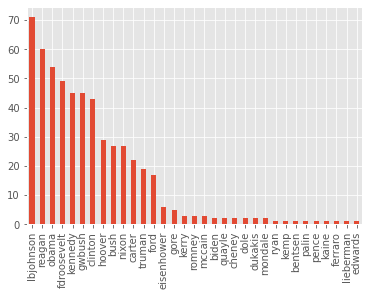

In [638]:
df['name'].value_counts().plot(kind='bar')

LBJ had the most speeches, which lead me to wonder if these were disproportionately press conferences due to the Vietnam War.  It turns out that yes, he had the most press conferences in the corpus, 23 in total.

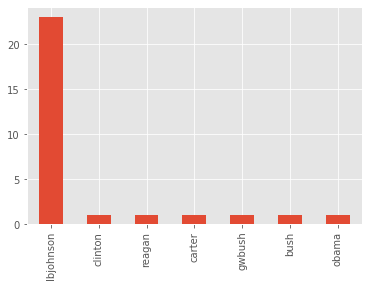

In [639]:
df[df['press conference']== True]['name'].value_counts().plot(kind='bar')

In [640]:
df.groupby('name').sum()

,index,interview,debate,inaugural address,state of the union,press conference
name,,,,,,
bentsen,46,0.0,1.0,0.0,0.0,0.0
biden,18,0.0,2.0,0.0,0.0,0.0
bush,429,0.0,6.0,1.0,3.0,1.0
carter,737,0.0,4.0,1.0,3.0,1.0
cheney,51,0.0,2.0,0.0,0.0,0.0
clinton,2614,0.0,5.0,0.0,7.0,1.0
dole,43,0.0,2.0,0.0,0.0,0.0
dukakis,46,0.0,2.0,0.0,0.0,0.0
edwards,23,0.0,1.0,0.0,0.0,0.0


In [685]:
df['text length'] = df.text.apply(lambda x: len(x.split(' ')))

Assuming 150 words spoken per minute, speeches were on average 23 minutes long

In [643]:
df['text length'].median()/150

21.173333333333332

In [644]:
df[df['party'] == 'democrat']['text length'].sum()

1118719

In [645]:
df[df['party'] == 'republican']['text length'].sum()

790496

In [646]:
df.sort_values(by='text length', ascending=True)

,index,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length
544,45,dukakis,democrat,0,0,0,0,,False,True,False,False,False,1
120,120,fdroosevelt,democrat,war,"<title=""Message to Congress Requesting War Dec...",Message to Congress Requesting War Declaration...,"December 11, 1941","<title=""Message to Congress Requesting War Dec...",False,False,False,False,False,144
202,202,hoover,republican,nw,"<title=""Message Regarding “Black Thursday”"">\n...",Message Regarding “Black Thursday”,"October 25, 1929",\n<IN REPLY to press questions as to the busin...,False,False,False,False,False,204
307,307,lbjohnson,democrat,war,"<title=""Statement on Sending Troops to the Dom...",Statement on Sending Troops to the Dominican R...,"April 28, 1965",\nI have just concluded a meeting with the lea...,False,False,False,False,False,241
355,355,nixon,republican,war,"<title=""Remarks Announcing an Agreement on Str...",Remarks Announcing an Agreement on Strategic A...,"May 20, 1971","\nGood afternoon, ladies and gentlemen:\nAs yo...",False,False,False,False,False,264
480,480,truman,democrat,war,"<title=""Victory Celebration"">\n<date=""November...",Victory Celebration,"November 3, 1948","\nMr. Mayor, and my fellow townsmen and citize...",False,False,False,False,False,277
432,432,reagan,republican,nw,"<title=""Remarks at the Veteran&#8217;s Day Cer...",Remarks at the Veteran&#8217;s Day Ceremony,"November 11, 1988","\nThank you very much, thank you. Please be se...",False,False,False,False,False,277
200,200,hoover,republican,nw,"<title=""Message Regarding Unemployment Relief""...",Message Regarding Unemployment Relief,"December 9, 1930","\n<THE PRESIDENT said:>\n""I observe that measu...",False,False,False,False,False,305
319,319,lbjohnson,democrat,war,"<title=""Remarks on Departing for the Asia-Paci...",Remarks on Departing for the Asia-Pacific Trip,"October 17, 1966","\nSecretary Rusk, and members of the Cabinet, ...",False,False,False,False,False,320
118,118,fdroosevelt,democrat,war,"<title=""The Tehran Declaration"">\n<date=""Decem...",The Tehran Declaration,"December 1, 1943","\nDeclaration of the Three Powers:\nWe, The Pr...",False,False,False,False,False,339


In [647]:
df.iloc[120].text

'<title="Message to Congress Requesting War Declarations with Germany and Italy">\n<date="December 11, 1941">\nTo the Congress:\nOn the morning of December eleventh, the Government of Germany, pursuing its course of world conquest, declared war against the United States.\nThe long known and the long expected has thus taken place. The forces endeavoring to enslave the entire world now are moving toward this hemisphere.\nNever before has there been a greater challenge to life, liberty, and civilization.\nDelay invites greater danger. Rapid and united effort by all of the peoples of the world who are determined to remain free will insure a world victory of the forces of justice and of righteousness over the forces of savagery and of barbarism.\nItaly also has declared war against the United States.\nI therefore request the Congress to recognize a state of war between the United States and Germany, and between the United States and Italy.\n'

In [648]:
vocab = set()
total = []
df['text'].str.lower().str.split().apply(vocab.update)
df['text'].str.lower().str.split().apply(total.append)
total = [item for sublist in total for item in sublist]
print(f'The vocabulary of the corpus is {len(vocab)} unique words & {len(total)} total words.')

The vocabulary of the corpus is 57629 unique words & 1928737 total words.


In [649]:
new = df.copy()

In [94]:
print('According to the count vectorizer the number of words is 25518')

According to the count vectorizer the number of words is 25518


In [244]:
count_vector = CountVectorizer(stop_words='english', max_features=None)
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
BoW = pd.DataFrame(X.toarray(), columns=labels)


Text(0.5, 1.0, 'Word Count by Party')

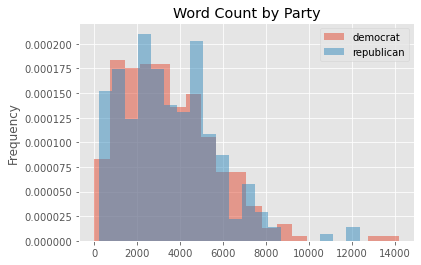

In [650]:
fig, ax = plt.subplots()
df[df['party'] == 'democrat']['text length'].plot(kind = 'hist', bins = 20, density = 'true', alpha = .5, label = 'democrat')
df[df['party'] == 'republican']['text length'].plot(kind = 'hist', bins = 20, density = 'true', alpha = .5, label = 'republican')
ax.legend()
ax.set_title('Word Count by Party')

## Looking at words by president!

In [653]:
words_by_pres = df.groupby(['name'])['text'].apply(lambda x: ','.join(x)).reset_index()


In [654]:
words_by_pres['length'] = words_by_pres['text'].apply(lambda x: len(x.split(' ')))

In [ ]:
pd.concat([words_by_pres.length, df.name.value_counts()], axis = 1)

Of the top 16, politicians with the highest term frequency of "woman" 5 were Republicans and 11 were Democrats.

Of the bottom 16, it was 10 Repbulicans and 6 Democrats

In [253]:
BoW.sort_values('woman', ascending = False)

KeyError: 'woman'

In [254]:
pd.options.display.max_columns = 200

In [255]:
BoW.sort_values('tax', ascending = False)

,000,action,administration,ago,america,american,americans,back,believe,best,better,bill,billion,business,cannot,care,change,children,congress,continue,country,done,economic,economy,end,federal,forces,free,freedom,future,give,good,got,government,great,health,help,history,home,hope,important,jobs,keep,know,law,life,long,look,military,million,much,nation,national,nations,need,never,new,next,nuclear,peace,people,percent,plan,policy,power,president,program,progress,public,put,right,rights,said,security,see,soviet,state,states,still,support,sure,system,take,tax,thank,things,think,together,tonight,union,united,us,use,war,well,without,work,working,world,years
247,11,3,6,1,2,13,1,0,1,0,0,1,4,20,6,0,4,0,9,2,4,1,16,11,1,7,1,5,1,4,5,0,0,6,3,0,2,1,5,0,6,4,3,2,7,3,4,0,0,8,5,1,1,0,10,1,28,4,0,0,8,8,1,4,1,0,8,0,11,0,0,1,0,2,0,0,0,13,1,1,0,30,5,165,0,0,0,2,0,0,13,7,12,2,15,6,1,0,9,8
447,4,1,0,2,10,3,3,7,2,2,4,23,3,6,1,0,3,1,4,2,2,4,12,6,1,5,0,2,1,6,4,1,0,15,4,0,4,2,2,3,2,3,3,3,0,4,0,0,0,0,7,4,0,0,4,7,4,3,0,0,11,13,5,1,1,1,12,0,0,5,2,0,5,7,9,0,1,1,2,3,1,3,4,54,1,2,0,3,1,0,0,8,0,0,8,1,3,2,3,20
534,1,3,19,6,36,22,4,1,7,4,4,12,5,5,10,0,5,6,4,1,30,4,2,35,0,8,0,3,0,0,5,2,9,12,3,0,1,4,5,0,7,12,1,3,3,11,3,3,0,4,3,7,3,1,28,1,13,9,0,0,38,15,5,13,0,19,2,2,8,5,3,2,16,6,2,0,2,11,2,0,4,9,8,49,3,1,16,2,1,0,11,13,4,3,19,8,18,8,16,25
414,1,0,2,3,1,1,6,3,3,1,2,11,18,3,0,0,0,1,7,1,0,2,8,4,3,3,1,0,0,0,1,0,1,17,2,0,4,6,2,2,1,4,0,6,0,0,3,3,0,2,1,1,3,0,3,0,6,4,0,0,7,15,2,3,1,2,9,0,0,2,4,0,6,0,3,0,2,2,4,5,1,4,1,45,1,1,2,1,1,0,0,8,2,0,9,2,4,1,0,12
490,13,2,3,3,4,5,1,2,7,2,6,9,26,4,2,0,0,4,39,0,14,7,1,12,2,26,0,0,1,3,15,11,2,16,4,1,4,7,0,1,2,24,2,3,1,3,0,3,2,13,3,3,4,0,2,3,5,6,1,0,19,13,1,2,2,22,12,0,1,0,3,1,4,3,2,0,2,12,4,0,2,3,5,37,0,1,22,2,2,1,12,7,0,2,7,0,5,7,0,21
508,7,0,0,1,17,5,4,10,8,5,5,0,15,11,0,15,2,2,2,2,7,9,4,11,0,10,0,4,1,2,4,8,3,15,6,13,4,0,1,1,4,17,7,12,0,3,2,10,6,10,3,5,2,0,11,1,6,2,0,0,53,14,23,0,0,31,5,0,0,13,17,3,26,3,5,0,17,3,2,2,8,1,14,29,4,6,10,3,0,0,0,6,0,0,20,1,12,4,5,10
533,12,5,3,8,21,8,2,3,8,1,3,18,5,6,1,1,1,5,7,0,11,1,2,5,5,0,0,2,0,11,7,8,7,4,2,3,1,3,5,3,8,22,0,6,5,0,0,2,1,23,9,3,2,0,1,5,29,5,0,3,17,7,43,4,0,27,0,6,0,7,12,2,29,0,2,0,0,14,2,3,0,2,8,28,4,0,14,2,7,0,14,4,3,1,8,1,7,8,7,29
505,13,3,0,0,7,12,4,6,5,3,1,2,8,0,1,8,2,2,2,6,10,6,1,4,4,1,7,2,0,0,5,4,6,4,5,3,8,1,1,2,1,5,7,19,1,5,3,22,8,14,3,1,1,2,16,7,2,3,5,2,46,16,1,5,0,18,3,0,1,9,10,0,34,13,2,0,1,5,1,3,10,1,16,27,2,5,7,3,1,0,7,14,3,12,13,1,4,5,12,5
446,1,0,1,0,7,7,2,0,1,3,1,7,0,1,1,0,0,3,2,0,3,1,8,4,1,0,0,0,4,1,0,1,0,5,0,0,0,6,1,5,1,2,1,2,1,4,4,0,0,1,1,4,0,1,0,3,5,1,0,0,5,2,1,0,0,0,1,1,0,1,0,2,1,1,1,0,0,2,0,0,0,0,1,27,3,0,1,0,0,0,2,6,0,0,1,1,5,1,3,3
184,2,0,1,3,2,5,3,1,0,0,0,1,0,1,0,0,0,0,4,0,2,0,1,0,0,2,0,0,1,0,0,2,0,2,2,0,0,0,1,0,1,0,0,0,0,1,1,2,0,0,2,1,0,0,0,0,4,0,0,0,5,2,2,1,0,4,0,1,0,0,0,0,1,0,0,0,0,3,0,0,0,0,1,26,5,0,0,1,0,1,3,2,0,1,2,0,1,2,1,1


In [26]:
def get_top_features(feature_logs, labels, num_features):
    ## returns the top featurs for dems, republications, as well as the features that are unique to 
    #each party in the top num_features
    zero_all = np.array(labels)[np.argsort(feature_logs[0])[-1*num_features:]]
    one_all = np.array(labels)[np.argsort(feature_logs[1])[-1*num_features:]]
    zero_unique = [x for x in zero_all if x not in one_all]
    one_unique = [x for x in one_all if x not in zero_all]
    return zero_all, one_all, zero_unique, one_unique
    
    

## the most important features for each class after the 200 word, 3 n-gram


# Main Test - Multinomial Bayes

In [27]:
sw = stopwords.words('english')

new_sw = ['also', '000', 'see', 'come', 'day','say', 'us', 'well', 'le', "'m", 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'cannot', 'two', 'long', 'said', 'like', 'years', 'think','would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)



In [30]:
## Now with only trigrams!
def run_model(X, y, max_feat = 1500, stop_words = sw):
    tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (3,3), max_features = max_feat)
    X = tfidf.fit_transform(X)
    labels = tfidf.get_feature_names()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 5)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    cvs = np.mean(cross_val_score(clf, X_train, y_train))
    return clf, cvs, X_test, y_test, labels, X, tfidf
    
clf, cvs, X_test, y_test, labels, X, tfidf = run_model(df.text, df.party, stop_words = sw)

td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')
print(cvs)

zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

# print(f'zero: {zero}')
# print(f'one: {one}')
print(f'Dem unique: {zero_unique}')
print(f'Rep unique: {one_unique}')

True Dems: 75, False Republicans: 6, False Dems: 16, True Republicans: 41
Recall for Democrats: 0.9259259259259259
Recall for Republicans: 0.7192982456140351
0.7931824860417278
Dem unique: ['health care reform', 'third world war', 'nuclear arms race', 'strength united states', 'executive branch government', 'voting rights act', 'president members congress', 'social security medicare', 'soldiers sailors marines', 'hundred million dollars', 'support american people', 'spread nuclear weapons', 'people back work', 'policy united states', 'north viet nam', 'government south vietnam', 'united states nation', 'world ever known', 'health care costs', 'chiang kai shek', 'god bless united', 'constitution united states', 'million new jobs', 'test ban treaty', 'general de gaulle', 'civil rights bill', 'united states government', 'bless united states', 'peace loving nations', 'people south vietnam', 'bless god bless', 'god bless god', 'martin luther king', 'middle class families', 'joint chiefs sta

In [747]:
trump = pd.Series(trump_speeches[0:11] + trump_speeches[13])

TypeError: can only concatenate list (not "str") to list

In [749]:
trump = trump.drop(12)

In [750]:
trump_vector = tfidf.fit_transform(trump)

In [751]:
print(clf.predict_proba(trump_vector)[:,0])

[0.5863747  0.51176675 0.46106733 0.67431799 0.71221315 0.54061495
 0.44888981 0.65072687 0.45917179 0.66780336 0.59354757 0.59632782
 0.44227937]


In [705]:
X_test.shape

(138, 9750)

## Main Accuracy Scorer

In [33]:
dem_prob = clf.predict_proba(X_test)[:,0]
correct = []
idx = list(y_test.index)
t = .54
print(y_test.shape)

y_test_array = y_test.to_numpy()
for i,v in enumerate(dem_prob):
    if v >= t and y_test_array[i] =='democrat':
        correct.append(1)
        df.loc[idx[i], 'accurate'] = True
    elif v<t and y_test_array[i] == 'republican':
        correct.append(1)
        df.loc[idx[i], 'accurate'] = True
    else:
        correct.append(0)
        df.loc[idx[i], 'accurate'] = False
print(f'Accuracy: {mean(correct)}')

(138,)
Accuracy: 0.8695652173913043


## Looking at log probabilities to find the most "democratic" and "republican" speeches

In [756]:
prob_repub_list = []
sorted_idx = np.argsort(clf.predict_proba(X_test)[:, 0])
                        
for i,v in enumerate(list(clf.predict_proba(X_test))):
    prob = v[0]
    idx = list(y_test.index)[i]
    prob_repub_list.append([prob, idx])

In [759]:
df.iloc[np.array(prob_repub_list)[sorted_idx][:10,1]]

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length
448,reagan,republican,nw,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 25, 1983","\nMr. Speaker, Mr. President, distinguished Me...",False,False,False,True,False,5503
438,reagan,republican,nw,"<title=""Farewell Address at the Republican Nat...",Farewell Address at the Republican National Co...,"August 15, 1988","\nMadam Chairman, delegates to the convention,...",False,False,False,False,False,4483
169,gwbush,republican,war,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 28, 2008","\nMadam Speaker, Vice President Cheney, member...",False,False,False,True,False,5635
465,reagan,republican,nw,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 25, 1984","\nMr. Speaker, Mr. President, distinguished me...",False,False,False,True,False,4891
165,gwbush,republican,war,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 23, 2007",\nThank you very much. And tonight I have the ...,False,False,False,True,False,5506
219,hoover,republican,nw,"<title=""Campaign speech in Indianapolis, India...","Campaign speech in Indianapolis, Indiana.","October 28, 1932","\nMy fellow citizens, my friends in Indianapol...",False,False,False,False,False,8557
466,reagan,republican,nw,"<title=""Speech to the Nation on Lebanon and Gr...",Speech to the Nation on Lebanon and Grenada,"October 27, 1983",\n\nMy fellow Americans:\nSome 2 months ago we...,False,False,False,False,False,8167
357,nixon,republican,war,"<title=""Address to the Nation Announcing Decis...",Address to the Nation Announcing Decision To R...,"August 8, 1974","<title=""Address to the Nation Announcing Decis...",False,False,False,False,False,1776
431,reagan,republican,nw,"<title=""State of the Union Address"">\n<date=""F...",State of the Union Address,"February 4, 1986","\nMr. Speaker, Mr. President, distinguished Me...",False,False,False,True,False,3461
6,bush,republican,war,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 28, 1992","\nMr. Speaker and Mr. President, distinguished...",False,False,False,True,False,5080


In [760]:
df.iloc[np.array(prob_repub_list)[sorted_idx][-10:,1]]

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length
50,clinton,democrat,nw,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 23, 1996","\nMr. Speaker, Mr. Vice President, members of ...",False,False,False,True,False,6239
321,lbjohnson,democrat,war,"<title=""Remarks on Receiving the National Free...",Remarks on Receiving the National Freedom Award,"February 23, 1966","\nMr. Chief Justice, Mr. Secretary, Senator Ke...",False,False,False,False,False,3864
362,obama,democrat,war,"<title=""Acceptance Speech at the Democratic Na...",Acceptance Speech at the Democratic National C...,"August 28, 2008",\nTo Chairman Dean and my great friend Dick Du...,False,False,False,False,False,4610
275,lbjohnson,democrat,war,"<title=""Press Conference"">\n<date=""October 6, ...",Press Conference,"October 6, 1966","\n\n<THE PRESIDENT.> Good afternoon, ladies an...",False,False,False,False,True,3877
316,lbjohnson,democrat,war,"<title=""Press Conference at the White House"">\...",Press Conference at the White House,"March 13, 1965","\n\n<THE PRESIDENT.> Good afternoon, ladies an...",False,False,False,False,True,3884
314,lbjohnson,democrat,war,"<title=""Press Conference at the State Departme...",Press Conference at the State Department,"April 16, 1964","\n\n<THE PRESIDENT.> Ladies and gentlemen, I h...",False,False,False,False,True,4560
284,lbjohnson,democrat,war,"<title=""Speech to the Associated Press Luncheo...",Speech to the Associated Press Luncheon,"April 20, 1964",\nPaul Miller and my fellow Americans: Last Fr...,False,False,False,False,False,8686
317,lbjohnson,democrat,war,"<title=""Press Conference"">\n<date=""February 4,...",Press Conference,"February 4, 1965",\nToday I am sending to the Congress my agricu...,False,False,False,False,True,4444
294,lbjohnson,democrat,war,"<title=""Address at Johns Hopkins University"">\...",Address at Johns Hopkins University,"April 7, 1965","\nMr. Garland, Senator Brewster, Senator Tydin...",False,False,False,False,False,5445
315,lbjohnson,democrat,war,"<title=""Press Conference in the East Room"">\n<...",Press Conference in the East Room,"July 13, 1965","\n\n<THE PRESIDENT.> Good afternoon, ladies an...",False,False,False,False,True,4232


LBJ appears in 4 of the top 5 spots.

Republicans: Reagan, GWBush (x2), Hoover, Bush Senior.

In [164]:
### Build confusion matrix:

## Looking at correct/incorrect data

In [761]:
df['accurate'] = 'na'
pred = []
idx = list(y_test.index)
for i, v in enumerate(list(y_test)):
    if v == clf.predict(X_test)[i]:
        df.loc[idx[i], 'accurate'] = True
    else:
        df.loc[idx[i], 'accurate'] = False

In [139]:
## Updates DF with whether the speech was accurately tagged

In [762]:
incorrect = df[df['accurate']==False]
incorrect.party.value_counts()

republican    17
democrat       8
Name: party, dtype: int64

In [763]:
incorrect.debate.value_counts()

False    21
True      4
Name: debate, dtype: int64

In [764]:
correct = df[df['accurate']==True]

In [765]:
correct.debate.value_counts()

False    110
True      26
Name: debate, dtype: int64

In [595]:
df.debate.value_counts()

False    473
True      76
Name: debate, dtype: int64

In [766]:
correct = df[df['accurate']==True]

In [767]:
incorrect.loc[:,['name', 'title']]

,name,title
5,bush,Debate with Bill Clinton and Ross Perot
30,carter,Speech on Establishing Diplomatic Relations wi...
61,clinton,Statement on His Testimony Before the Grand Jury
102,fdroosevelt,Fireside Chat 1: On the Banking Crisis
107,fdroosevelt,Fireside Chat 11: On the Unemployment Census
134,fdroosevelt,Democratic National Convention
158,gwbush,Remarks on the War on Terror
172,gwbush,Remarks on Emergency Economic Stabilization Ac...
177,gwbush,First Inaugural Address
204,hoover,Message Regarding Law Enforcement


## To do:
- ROC Curve/Threshold
- Take out debates
- Take out LBJ
- Look up uses of top words


## Wednesday Notes

Model has great recall for Democrats, bad recall for republicans.  Nixon has the most misclassifications (Checkers!).
Debates are poorly classified.

## Checking for best features

In [35]:
feat = np.arange(500, 10000, 250)
acc = []
recall_dems = []
recall_rep = []
for i in feat:
    clf, cvs, X_test, y_test, _, _, _ = run_model(df.text, df.party, max_feat = i, stop_words = sw)
    td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
    recall_d = td/(td + fr)
    recall_r = tr/(fd + tr)
    acc.append(cvs)
    recall_dems.append(recall_d)
    recall_rep.append(recall_r)


Plotting accuracy and recall vs the number of features.

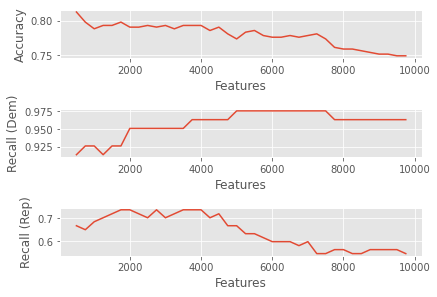

In [43]:
fig, ax = plt.subplots(3,1)

ax[0].plot(feat, acc)
ax[0].set_xlabel('Features')
ax[0].set_ylabel('Accuracy')
ax[1].plot(feat, recall_dems)
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Recall (Dem)')
#ax[0].scatter([feat[np.argsort(acc)[-5:]]], acc[np.argsort(acc)[-5:]])
#ax[0].title('Features vs Accuracy')
ax[2].plot(feat, recall_rep)
ax[2].set_xlabel('Features')
ax[2].set_ylabel('Recall (Rep)')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

As the features grew, the model began to classify more people as Democrats.  Maybe this means that republicans have a few defining words, but when the pool is broadened to more words, it gets diluted

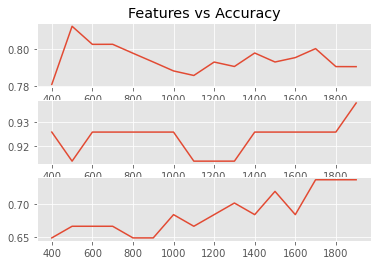

In [45]:
feat = np.arange(400, 2000, 100)
acc_small = []
recall_dems_small = []
recall_rep_small = []
for i in feat:
    clf, cvs, X_test, y_test, _, _, _, = run_model(df.text, df.party, max_feat = i, stop_words = sw)
    td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
    recall_d = td/(td + fr)
    recall_r = tr/(fd + tr)
    acc_small.append(cvs)
    recall_dems_small.append(recall_d)
    recall_rep_small.append(recall_r)

fig, ax = plt.subplots(3,1)

ax[0].plot(feat, acc_small)
ax[0].set_title('Features vs Accuracy')
ax[1].plot(feat, recall_dems_small)
#ax[0].scatter([feat[np.argsort(acc)[-5:]]], acc[np.argsort(acc)[-5:]])
#ax[0].title('Features vs Accuracy')
ax[2].plot(feat, recall_rep_small)

In [353]:
list(feat[np.argsort(acc)[-5:]])

[1500, 7000, 11750, 13000, 13750]

In [347]:
feat[np.argsort(acc)[-5:]]

array([ 1500,  7000, 11750, 13000, 13750])

## ROC Curves

In [379]:
clf, cvs, X_test, y_test = run_model(df.text, df.party, max_feat = 1300, stop_words = sw)

In [46]:
td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')

True Dems: 76, False Republicans: 5, False Dems: 15, True Republicans: 42
Recall for Democrats: 0.9382716049382716
Recall for Republicans: 0.7368421052631579


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.918


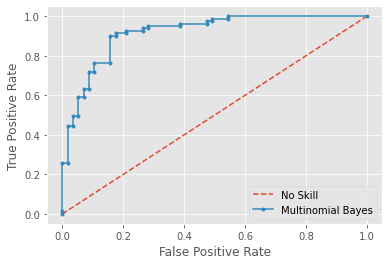

In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


# generate a no skill prediction (majority class)
y_test_coded = []
for i in y_test:
    if i == 'democrat':
        y_test_coded.append(1)
    else:
        y_test_coded.append(0)
    
    
ns_probs = [0 for _ in range(len(y_test))]
mnb_probs = clf.predict_proba(X_test)
# keep probabilities for being a republican only (column 1), democrat (column 0)
mnb_probs = mnb_probs[:, 0]
# calculate scores
ns_auc = roc_auc_score(y_test_coded, ns_probs)
mnb_auc = roc_auc_score(y_test_coded, mnb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (mnb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_coded, ns_probs)
mnb_fpr, mnb_tpr, _ = roc_curve(y_test_coded, mnb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(mnb_fpr, mnb_tpr, marker='.', label='Multinomial Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
Credit goes to https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [ ]:
Credit goes to: https://www.scikit-yb.org/en/latest/api/classifier/threshold.html

### Plotting Accuracy Curves for different thresholds:

In [438]:
y_test_array = y_test.to_numpy()

Text(0, 0.5, 'Accuracy')

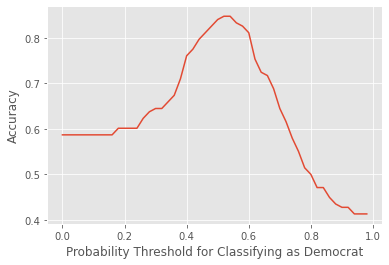

In [755]:
from statistics import mean
dem_prob = clf.predict_proba(X_test)[:,0]
thresh = np.arange(0,1, .02)
y_test
thresh_acc =[]

for t in thresh:
    correct = []
    for i,v in enumerate(dem_prob):
        if v >= t and y_test_array[i] =='democrat':
            correct.append(1)
        elif v<t and y_test_array[i] == 'republican':
            correct.append(1)
        else:
            correct.append(0)
    thresh_acc.append(mean(correct))

fig, ax = plt.subplots()
ax.plot(thresh, thresh_acc)
ax.set_xlabel('Probability Threshold for Classifying as Democrat')
ax.set_ylabel('Accuracy')
    

## Random Forest

In [609]:
### fitted with grid search results
from sklearn.ensemble import RandomForestClassifier
overall_acc = []
# for i in range(10):
#     X_train, y_train, X_test, y_test = train_test_split(df.text, df.party, stratify = df.party, random_state = i)
#     rf = RandomForestClassifier()
#     rf = rf.fit(X_train, y_train)
#     acc = mean(cross_val_score(rf, X_train, y_train))
#     overall_acc.apend(acc)

# print(mean(overall_acc))

tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (1,3), max_features = 1500)
X = tfidf.fit_transform(df.text)
labels = tfidf.get_feature_names()
X_train, X_test, y_train, y_test = train_test_split(X, df.party, stratify = df.party, random_state = 5)
rf = RandomForestClassifier(n_estimators = 600, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt',
                           max_depth = 115, bootstrap = False)
rf = rf.fit(X_train, y_train)
acc = mean(cross_val_score(rf, X_train, y_train))

pred = rf.predict(X_test)
dem_prob_rf = rf.predict_proba(X_test)


In [612]:
y_test_array = y_test.to_numpy()
correct = []
t = .54
for i,v in enumerate(dem_prob_rf[:, 0]):
    if v >= t and y_test_array[i] =='democrat':
        correct.append(1)
        print(f'said that t = {t}, i = {i}, v={v} and y_test = {y_test_array[i]} is correct')
    elif v<t and y_test_array[i] == 'republican':
        correct.append(1)
    else:
        correct.append(0)
print(f'Accuracy: {mean(correct)}')

said that t = 0.54, i = 1, v=0.7791666666666666 and y_test = democrat is correct
said that t = 0.54, i = 3, v=0.6091666666666666 and y_test = democrat is correct
said that t = 0.54, i = 7, v=0.6158333333333335 and y_test = democrat is correct
said that t = 0.54, i = 8, v=0.6443055555555556 and y_test = democrat is correct
said that t = 0.54, i = 9, v=0.622222222222222 and y_test = democrat is correct
said that t = 0.54, i = 11, v=0.5894444444444444 and y_test = democrat is correct
said that t = 0.54, i = 12, v=0.7904166666666668 and y_test = democrat is correct
said that t = 0.54, i = 13, v=0.7126388888888887 and y_test = democrat is correct
said that t = 0.54, i = 15, v=0.7995833333333332 and y_test = democrat is correct
said that t = 0.54, i = 16, v=0.5529166666666666 and y_test = democrat is correct
said that t = 0.54, i = 17, v=0.587222222222222 and y_test = democrat is correct
said that t = 0.54, i = 18, v=0.6559722222222222 and y_test = democrat is correct
said that t = 0.54, i =

In [482]:
acc

0.7883338230972672

said that t = 0.0, i = 0, v=0.6884722222222223 and y_test = democrat is correct
said that t = 0.0, i = 1, v=0.5929166666666668 and y_test = democrat is correct
said that t = 0.0, i = 2, v=0.7059722222222222 and y_test = democrat is correct
said that t = 0.0, i = 3, v=0.700138888888889 and y_test = democrat is correct
said that t = 0.0, i = 4, v=0.7090277777777778 and y_test = democrat is correct
said that t = 0.0, i = 5, v=0.7908333333333333 and y_test = democrat is correct
said that t = 0.0, i = 6, v=0.5440277777777777 and y_test = democrat is correct
said that t = 0.0, i = 8, v=0.6088888888888887 and y_test = democrat is correct
said that t = 0.0, i = 11, v=0.614722222222222 and y_test = democrat is correct
said that t = 0.0, i = 14, v=0.706388888888889 and y_test = democrat is correct
said that t = 0.0, i = 16, v=0.6574999999999999 and y_test = democrat is correct
said that t = 0.0, i = 19, v=0.5634722222222222 and y_test = democrat is correct
said that t = 0.0, i = 20, v=0.64763888

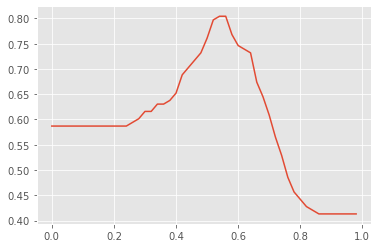

In [483]:
y_test_array = y_test.to_numpy()
dem_prob = rf.predict_proba(X_test)[:,0]
thresh = np.arange(0,1, .02)
thresh_acc =[]

for t in thresh:
    correct = []
    for i,v in enumerate(dem_prob):
        if v >= t and y_test_array[i] =='democrat':
            correct.append(1)
            print(f'said that t = {t}, i = {i}, v={v} and y_test = {y_test_array[i]} is correct')
        elif v<t and y_test_array[i] == 'republican':
            correct.append(1)
            print(f'said that t = {t}, i = {i}, v={v} and y_test = {y_test_array[i]} is correct')
        else:
            correct.append(0)

    thresh_acc.append(mean(correct))

fig, ax = plt.subplots()
ax.plot(thresh, thresh_acc)

The best threshold is .54

In [494]:
important = rf.feature_importances_
idx = np.argsort(important)[-20:]

np.array(labels)[idx]

array(['allow', 'funding', 'major', 'inflation', 'terrorist', 'country',
       'friends', 'terrorists', 'men', 'think', 'reagan', 'economic',
       'spending', 'rates', 'federal', 'federal government', 'race',
       'bless', 'taxes', 'god bless'], dtype='<U23')

In [487]:
thresh[np.argsort(thresh_acc)[-1:]]

array([0.54])

In [486]:
print(y_test_array)

['democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'republican' 'democrat' 'republican' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'republican' 'democrat' 'republican'
 'republican' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'democrat' 'democrat' 'republican' 'republican' 'republican'
 'democrat' 'republican' 'republican' 'democrat' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' 'democrat'
 'republican' 'democrat' 'republican' 'republican' 'republican' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'republican' 'republican' 'democrat' 'republican' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'democr

Grid search

In [464]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 220, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [543]:
#DON'T RUN THIS!!
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

## Best parameters
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 199, 'bootstrap': False}


In [ ]:
from sklearn.inspection import permutation_importance
importances = permutation_importance(rf, X_train, y_train).importances_mean

From https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

## Looking at log probabilities to find the most "democratic" and "republican" speeches

In [447]:
def get_most_partisan(clf, X_test, y_test):
    prob_dem_list = []
    sorted_idx = np.argsort(clf.predict_proba(X_test)[:, 0])
                        
    for i,v in enumerate(list(clf.predict_proba(X_test))):
        prob = v[0]
        idx = list(y_test.index)[i]
        prob_dem_list.append([prob, idx])
    most_rep_idx = np.array(prob_repub_list)[sorted_idx][:5,1]
    most_dem_idx = np.array(prob_dem_list)[sorted_idx][-5:,1]
    return most_rep_idx, most_dem_idx

most_rep, most_dem = get_most_partisan(clf, X_test, y_test)
print('Most Republican')
print(df.loc[most_rep, ['name', 'title']])
print('Most Democrat')
print(df.loc[most_dem, ['name', 'title']])

Most Republican
             name                                        title
163.0      gwbush                   State of the Union Address
455.0      reagan   Address to the Nation on National Security
35.0       carter              Address to the Nation on Energy
247.0     kennedy  Special Message to the Congress on Taxation
86.0   eisenhower                      First Inaugural Address
Most Democrat
            name                                      title
255.0    kennedy                    Address on Civil Rights
281.0  lbjohnson                           Press Conference
302.0  lbjohnson          Press Conference in the East Room
289.0  lbjohnson          Press Conference in the East Room
295.0  lbjohnson  Remarks on Vietnam at Syracuse University


LBJ appears in 4 of the top 5 spots.

Republicans: Reagan, GWBush (x2), Hoover, Bush Senior.

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length,accurate
11,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress on ...,"March 6, 1991","<title=""Address Before a Joint Session of Cong...",False,False,False,False,False,2773,True
11,mondale,democrat,0,0,0,0,One of the key tests of leadership is whether...,False,True,False,False,False,4445,True
11,obama,democrat,0,0,0,0,"well, thank you very much, jim, and thanks to...",False,True,False,False,False,13229,True


In [279]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 100)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero_unique}')
print(f'one unique: {one_unique}')

zero: ['end' 'energy' 'opportunity' 'done' 'billion' 'seek' 'place' 'nuclear'
 'land' 'plan' 'soviet' 'health' 'general' 'republican' 'human' 'common'
 'agreement' 'system' 'worker' 'history' 'woman' 'member' 'united nation'
 'better' 'party' 'economic' 'leader' 'see' 'care' 'back' 'never' 'act'
 'thank' 'viet-nam' 'still' 'responsibility' 'change' 'said' 'south'
 'citizen' 'long' 'interest' 'without' 'action' 'tax' 'home' 'economy'
 'community' 'together' 'military' 'much' 'give' 'well' 'take' 'program'
 'free' 'million' 'law' 'business' 'policy' 'problem' 'national' 'family'
 'security' 'future' 'tonight' 'power' 'believe' 'effort' 'good' 'bill'
 'child' 'hope' 'freedom' 'help' 'vietnam' 'job' 'need' 'life' 'force'
 'great' 'united state' 'congress' 'know' 'right' 'work' 'government'
 'america' 'think' 'united' 'new' 'country' 'state' 'peace' 'war'
 'president' 'world' 'nation' 'american' 'people']
one: ['east' 'interest' 'administration' 'toward' 'yet' 'ago' 'think' 'bill'
 'party' 

In [154]:
sw = stopwords.words('english')

new_sw = ['also', 'day','two', 'even', 'dont',"'ll", 'say', 'want', 'time', 'come', 'make', 'thing', 'le', "'m", 'go', 'thats', 'could', 'like', 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)


In [164]:
### Build confusion matrix:

In [130]:
print(clf.predict(X_test))
print(y_test)

['democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat

## Looking at correct/incorrect data

In [535]:
df['accurate'] = 'na'
pred = []
idx = list(y_test.index)
for i, v in enumerate(list(y_test)):
    if v == clf.predict(X_test)[i]:
        df.loc[idx[i], 'accurate'] = True
    else:
        df.loc[idx[i], 'accurate'] = False

In [536]:
## Updates DF with whether the speech was accurately tagged

In [537]:
incorrect = df[df['accurate']==False]
incorrect.party.value_counts()

republican    24
democrat       8
Name: party, dtype: int64

In [538]:
incorrect.debate.value_counts()

False    26
True      6
Name: debate, dtype: int64

In [539]:
correct.debate.value_counts()

False    97
True      9
Name: debate, dtype: int64

In [542]:
correct.party.value_counts()

democrat      73
republican    33
Name: party, dtype: int64

In [540]:
df.debate.value_counts()

False    473
True      76
Name: debate, dtype: int64

In [137]:
print((23 + 19)/(23 + 19 + 38 + 23))
print(76/473)


0.4077669902912621
0.160676532769556


In [121]:
correct = df[df['accurate']==True]

In [301]:
counts_wrong = incorrect['name'].value_counts()

In [309]:
counts_right = correct['name'].value_counts()

In [318]:
right_wrong = pd.concat([counts_wrong, counts_right], axis = 1)
right_wrong = right_wrong.fillna(0)
right_wrong['correct %'] = (1 - right_wrong.iloc[:, 0]/(right_wrong.iloc[:, 0] + right_wrong.iloc[:, 1]))*100


In [319]:
right_wrong

,name,name,correct %
reagan,12.0,5.0,29.411765
ford,6.0,0.0,0.000000
bush,5.0,4.0,44.444444
nixon,3.0,0.0,0.000000
gwbush,3.0,7.0,70.000000
hoover,2.0,4.0,66.666667
eisenhower,1.0,0.0,0.000000
obama,1.0,15.0,93.750000
kennedy,1.0,8.0,88.888889
lbjohnson,0.0,20.0,100.000000


In [ ]:

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## To do:
- ROC Curve/Threshold
- Take out debates
- Take out LBJ
- Look up uses of top words


## Wednesday Notes

Model has great recall for Democrats, bad recall for republicans.  Nixon has the most misclassifications (Checkers!).
Debates are poorly classified.

In [156]:
incorrect

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length,accurate
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False,False,3267,False
5,bush,republican,war,"<title=""Debate with Bill Clinton and Ross Pero...",Debate with Bill Clinton and Ross Perot,"October 11, 1992","Well, I think one thing that distinguishes is...",False,True,False,False,False,5597,False
6,bush,republican,war,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 28, 1992","\nMr. Speaker and Mr. President, distinguished...",False,False,False,True,False,5080,False
7,bush,republican,war,"<title=""Acceptance Speech at the Republican Na...",Acceptance Speech at the Republican National C...,"August 18, 1988",\nI have many friends to thank tonight. I than...,False,False,False,False,False,4127,False
8,bush,republican,war,"<title=""Press Conference with Mikhail Gorbache...",Press Conference with Mikhail Gorbachev,"July 31, 1991","\n\n<President Gorbachev. Good evening, ladies...",False,False,False,False,True,11902,False
10,bush,republican,war,"<title=""Address to the Nation on Panama"">\n<da...",Address to the Nation on Panama,"December 20, 1989","\nMy fellow citizens, last night I ordered U. ...",False,False,False,False,False,762,False
13,bush,republican,war,"<title=""Debate with Michael Dukakis"">\n<date=""...",Debate with Michael Dukakis,"September 25, 1988",I think we've seen a deterioration of values....,False,True,False,False,False,6135,False
23,carter,democrat,nw,"<title=""Debate with President Gerald Ford"">\n<...",Debate with President Gerald Ford,"October 6, 1976","Well, I think this Republican administration ...",False,True,False,False,False,5157,False
25,carter,democrat,nw,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 23, 1980","\nMr. President, Mr. Speaker, members of the 9...",False,False,False,True,False,3441,False
26,carter,democrat,nw,"<title=""Debate with President Gerald Ford"">\n<...",Debate with President Gerald Ford,"October 22, 1976","Well, I might say first of all, that I think ...",False,True,False,False,False,5281,False


In [163]:
print(df.loc[202,'text'])


<IN REPLY to press questions as to the business situation the President said:>
"The fundamental business of the country, that is the production and distribution of commodities, is on a sound and prosperous basis. The best evidence is that although production and consumption are at high levels, the average prices of commodities as a whole have not increased and there have been no appreciable increases in the stocks of manufactured goods. Moreover, there has been a tendency of wages to increase, the output per worker in many industries again shows an increase, all of which indicates a healthy condition.
"The construction and building material industries have been to some extent affected by the high interest rates induced by stock speculation and there has been some seasonal decrease in one or two other industries but these movements are of secondary character when considered in the whole situation.
"A temporary drop in grain prices sympathetically with stock exchange prices usually happ

In [114]:
df['name'].value_counts()
mis_class_by_pres = [['bush sr', 5/27], ['carter', 2/22], ['Eisenhower', 1/6], ['Ford', 2/17], 
                     ['GW', 7/45],['Hoover',4/29], ['Nixon', 6/27], ['Obama', 1/54], ['Reagan', 10/60]]
print(mis_class_by_pres)

[['bush sr', 0.18518518518518517], ['carter', 0.09090909090909091], ['Eisenhower', 0.16666666666666666], ['Ford', 0.11764705882352941], ['GW', 0.15555555555555556], ['Hoover', 0.13793103448275862], ['Nixon', 0.2222222222222222], ['Obama', 0.018518518518518517], ['Reagan', 0.16666666666666666]]


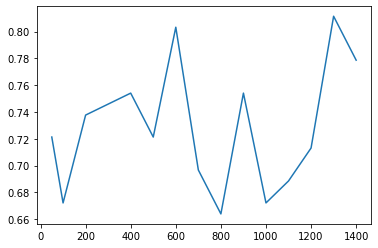

In [134]:
fig, ax = plt.subplots()
ax.plot(feat, scores)